In [44]:
from util._io import read_config
from collections import namedtuple
from pathlib import Path
import pandas as pd
import numpy as np
import fastsca
import logging
import _rpstruct as rp
import _pnmf
from sklearn.decomposition import NMF
from sklearn import preprocessing
import random
from scipy.special import softmax
from sklearn.metrics.cluster import contingency_matrix,silhouette_score,adjusted_rand_score,calinski_harabasz_score,davies_bouldin_score
np.random.seed(42)

experiment = '/projects/experiments/asapp/'
server = Path.home().as_posix()
experiment_home = server+experiment
experiment_config = read_config(experiment_home+'config.yaml')
args = namedtuple('Struct',experiment_config.keys())(*experiment_config.values())

sca = fastsca.FASTSCA()
sca.config = args
sca.initdata()
# sca.loaddata()
# print(sca.data.mtx.shape)
fn = sca.config.home + sca.config.experiment +sca.config.output + sca.config.sample_id+'/'+sca.config.sample_id



In [45]:
df_y = pd.read_csv(fn+'_rp_bulk.csv.gz')
df_y.shape


(1146, 19798)

In [2]:
import numpy as np
import pandas as pd
from numpy.random import normal
np.random.seed(37)

df_w = pd.DataFrame([
[0.8,0.15,0.05],
[0.75,0.15,0.1],
[0.8,0.15,0.05],
[0.75,0.15,0.1],
[0.15,0.05,0.8],
[0.15,0.05,0.8],
[0.15,0.05,0.8],
[0.15,0.05,0.8],
[0.05,0.8,0.15],
[0.05,0.8,0.15],
[0.05,0.8,0.15],
[0.05,0.8,0.15],
])

print('W m x k',df_w.shape)

a = list(normal(5,1,100)) + list(normal(1,1,100)) + list(normal(1,1,100))
b = list(normal(1,1,100)) + list(normal(1,1,100)) + list(normal(5,1,100))
c = list(normal(1,1,100)) + list(normal(5,1,100)) + list(normal(1,1,100))
df_h = pd.DataFrame([a,b,c])

print('H k x n',df_h.shape)


df_y = pd.DataFrame(np.dot(df_w.to_numpy(),df_h.to_numpy()))
print('A m x n',df_y.shape)


W m x k (12, 3)
H k x n (3, 300)
A m x n (12, 300)


#### Single Effect Factorization (SEF)

Instead of resolving $\eta_{bg} = \sum_{k} H_{bk} W_{gk}$ all at once,


For $k = 1$, 

$$\eta_{bg}^{(k)} = H_{bk} W_{gk}$$

For $k > 1$,

1. Update running average: $\eta_{bg}^{(k)} = \eta_{bg}^{(k-1)} +  H_{bk} W_{gk}$

2. Update quadratic approximation

    a. $\omega_{bg} = \exp(\eta)$
	
	b. $\tilde{Y}_{bg} = \eta_{bg} - 1 + Y_{bg} \exp(-\eta_{bg})$

    c. $L_{Q}^{(k)} = -\frac{1}{2} \sum_{bg} \omega_{bg} \left(\tilde{Y}_{bg} - H_{bk} W_{gk}\right)^{2}$

3. update the latent loading for all the batches $H$: 

    - $H_{bk} = \sum_{g} \omega_{bg} \tilde{Y}_{bg} W_{gk}/ ( \sum_{g} \omega_{bg} W_{gk}^{2} + \epsilon)$

4. update the gene selection probability $W$: 

    - $W_{gk} = \exp\left( -\frac{1}{2} \sum_{b} \omega_{bg} (\tilde{Y}_{bg} - H_{bk})^{2} \right)$ and $\sum_{g} W_{gk} = 1$





In [ ]:

y= np.matrix(df_y.iloc[:,0].T.to_numpy())
k = 3
g = y.shape[1]
b = y.shape[0]
W = np.matrix(np.random.rand(g,k))
H = np.matrix(np.random.rand(b,k))

# llik_res = []

for k_i in range(k):

    if k_i ==0:            
        eta = np.dot(H[:,k_i],W[:,k_i].T)
    else:
        eta =  eta + np.dot(H[:,k_i],W[:,k_i].T)
        omega = np.exp(eta)
        y_approx = eta - 1 + np.multiply(y,np.exp(-eta))

        llik = (-0.5 * np.square(np.multiply(omega , y_approx - np.dot(H[:,:k_i],W[:,:k_i].T)))).sum()
        frob_norm = np.linalg.norm(y - np.dot(H[:,:k_i],W[:,:k_i].T), 'fro')
        print(k_i,llik,frob_norm)

        hd = np.dot(omega,np.square(W[:,k_i])) + 1e-5
        y_approx_k = y_approx - np.dot(H[:,k_i],W[:,k_i].T)
        hn = np.dot(np.multiply(omega,y_approx_k),W[:,k_i])
        H[:,k_i] = hn/hd

        W_gk = np.exp(-0.5 * np.multiply(omega , np.square(y_approx - H[:,k_i])).sum(0))
        W[:,k_i] = softmax(W_gk).T



In [61]:
import numpy as np
import _nmf2
import importlib
importlib.reload(_nmf2)
model = _nmf2.nmf_solver(df_y.T.to_numpy(),10,5)


0
1
2
3
4


/home/BCCRC.CA/ssubedi/.conda/envs/ssubedi/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


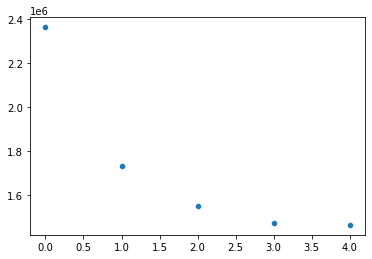

In [62]:
import seaborn as sns 
sns.scatterplot(range(len(model['loss'])),model['loss'])
H = model['H']
W = model['W']

In [63]:
import _topics_util as tpu 
import matplotlib.pylab as plt
import seaborn as sns

df_w = pd.DataFrame(W.T)
df_w.columns = sca.data.cols
df_top = tpu.get_topic_top_genes(df_w,10)

/home/BCCRC.CA/ssubedi/projects/experiments/asapp/asapp/_topics_util.py:8: FutureWarning: In a future version of pandas all arguments of Series.sort_values will be keyword-only.
  gtab = df.T.iloc[:,x].sort_values(0,ascending=False)[:top_n].reset_index()
/home/BCCRC.CA/ssubedi/projects/experiments/asapp/asapp/_topics_util.py:8: FutureWarning: In a future version of pandas all arguments of Series.sort_values will be keyword-only.
  gtab = df.T.iloc[:,x].sort_values(0,ascending=False)[:top_n].reset_index()
/home/BCCRC.CA/ssubedi/projects/experiments/asapp/asapp/_topics_util.py:8: FutureWarning: In a future version of pandas all arguments of Series.sort_values will be keyword-only.
  gtab = df.T.iloc[:,x].sort_values(0,ascending=False)[:top_n].reset_index()
/home/BCCRC.CA/ssubedi/projects/experiments/asapp/asapp/_topics_util.py:8: FutureWarning: In a future version of pandas all arguments of Series.sort_values will be keyword-only.
  gtab = df.T.iloc[:,x].sort_values(0,ascending=False)[:t

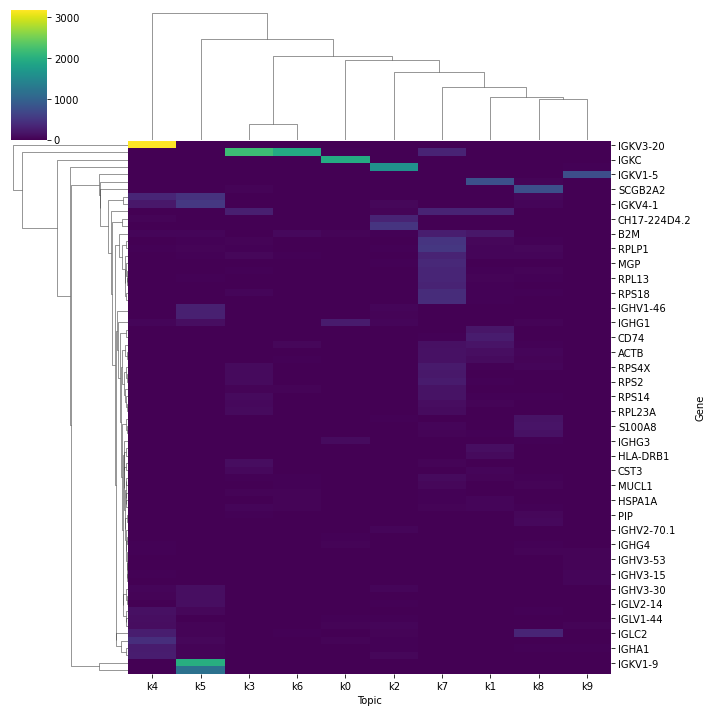

In [64]:
df_top = df_top.pivot(index='Topic',columns='Gene',values='Proportion')
sns.clustermap(df_top.T,cmap='viridis')

In [66]:
df_w.iloc[2,].sort_values(ascending=False).head(25)


IGLV1-40        1592.409723
IGLV3-19         476.841935
CH17-224D4.2     303.995813
IGKV4-1           57.927442
IGHV4-39          55.487613
                   ...     
IGHG3              2.614812
IGLV3-21           2.575745
RPS23              2.570900
RPL39              2.552428
H2AFJ              2.481670
Name: 2, Length: 100, dtype: float64